In [ ]:
# TODO:
# implement iterative policy evaluation of states
# Input: 
#   [<action>, .., ]
#   {<action>: <probability>}
#   gamma
#   {r(s'): <reward>}
#   map of world: ['SFFF', 
#                  'FHFH', 
#                  'FFFH', 
#                  'HFFG']
#   initial state: [row, col]

# Requirements:
#  + policy should be valid, i.e after fell into hole, no further actions are possibble 
#  + on return i get a map of states, e.g: 
# [[0.3, -0.04, 0.23, 0],
#  [0.3, -0.04, 0.23, 0]
#  [0.3, -0.04, 0.23, 0]
#  [0.3, -0.04, 0.23, 0]
#  [0.3, -0.04, 0.23, 0]] 
# 
# I should visualize the map (heat map)

In [1]:
import numpy as np

import seaborn

from functools import reduce

import copy
import matplotlib.pyplot as plt


In [5]:
actions_map = {"left": 0, 
               "down": 1, 
               "right": 2, 
               "up": 3}



In [ ]:
# environment:
# ['SFFF', 
#  'FHFH', 
#  'FFFH', 
#  'HFFG']

In [4]:
# initial state
s0 = (0, 0)
# probabilities to move by action
ps = {
      "left": 0.25, 
      "down": 0.25, 
      "right": 0.25, 
      "up": 0.25
    } 
# rewards to get when getting to a state
rs = {
      "H": 0,
      "F": 0,
      "S": 0,
      "G": 1
    }


world_map = ['SFFF', 
            'FHFH', 
            'FFFH', 
            'HFFG']

world_map = np.array([[env_name for env_name in line] for line in world_map])

gamma = 0.75


In [3]:
world_map

array([['S', 'F', 'F', 'F'],
       ['F', 'H', 'F', 'H'],
       ['F', 'F', 'F', 'H'],
       ['H', 'F', 'F', 'G']], dtype='<U1')

# (S) Experiment on iterative policy

In [7]:
world_map

array([['S', 'F', 'F', 'F'],
       ['F', 'H', 'F', 'H'],
       ['F', 'F', 'F', 'H'],
       ['H', 'F', 'F', 'G']], dtype='<U1')

# (E) Experiment on iterative policy

In [3]:
class OutOfWorldError(Exception):
    ...


def apply_policy(state_coords, policy):
    """returns next state"""
    move_col = {
        "left": -1,
        "right": 1}
    
    move_row = {
        "up": -1,
        "down": 1
    }
    
    steps = move_col.get(policy)
    new_coords = 0, 0
    if steps:
        new_coords = state_coords[0], state_coords[1] + steps
    else:
        steps = move_row.get(policy)
        new_coords = state_coords[0] + steps, state_coords[1]
    if new_coords[0] < 0 or new_coords[1] < 0: # both coords may be negative
        raise OutOfWorldError
    
    return new_coords


In [11]:
# strategies_chain = [
#     [["down"]*2, ["right"], ["down"], ["right"]*2],
#     [["down"]*2, ["right"]*2, ["down"], ["right"]],
#     [["right"]*3, ["left"], ["down"]*3, ["right"]],
#     [["right"]*2, ["down"]*3, ["right"]]
# ]
# strategies_chain[0]
# strategies_chain = list(map(lambda policy_chain: reduce(lambda x, y: x + y, 
#                                      policy_chain), 
#                                strategies_chain))


In [ ]:
# Var 2 (declarative)
# strategies_chain_coords = []
# for chain in strategies_chain:
#     coords_chain = [s0]
#     for policy in chain:
#         coords_chain.append(apply_policy(coords_chain[-1], policy))
#     strategies_chain_coords.append(coords_chain)


In [6]:
# Var 1 (functional)
# strategies_chain_coords = \
# [list(
#     reduce(lambda accum_states, policy: accum_states + [apply_policy(accum_states[-1], policy)],
#            strategy_chain,
#            [s0])) 
#     for strategy_chain in strategies_chain]


In [66]:
# history = []
# states = np.zeros((4, 4), dtype=np.float64)

# for i in range(len(strategies_chain_coords)):
#     state_coords = strategies_chain_coords[i]
#     policies = strategies_chain[i]

#     for next_i in range(-1, -(len(policies) + 1), -1):
#         curr_i = next_i - 1

#         next_state_env = world_map[state_coords[next_i]][0]
#         reward = rs.get(next_state_env)
#         probab = ps.get(policies[next_i])
#         states[state_coords[curr_i]] = probab*(reward + gamma*states[state_coords[next_i]])
    
#     history.append(copy.deepcopy(states))
    


In [ ]:
# fig, axes = plt.subplots(2, 2, figsize=(7, 7))


# for i, (ax, state_matrix) in enumerate(zip(axes.flat, history)):
#     seaborn.heatmap(state_matrix, ax=ax, annot=True, cbar=False)
#     ax.axis("off")
#     ax.set_title(f"States: {i}")

# plt.tight_layout()
# plt.show()


## (2.a) Policy iteration method for one strategy 

In [28]:
states = np.zeros((4, 4), dtype=np.float64)

strategy_chain = [["down"]*2, ["right"], ["down"], ["right"]*2]
strategy_chain = list(reduce(lambda a, b: a + b, strategy_chain))
s0 = (0, 0)

# form coords of movement
coords_chain = [s0]
for policy in strategy_chain:
    coords_chain.append(apply_policy(coords_chain[-1], policy))

for next_i in range(-1, -(len(strategy_chain) + 1), -1):
    curr_i = next_i - 1

    next_state_env = world_map[coords_chain[next_i]][0]
    reward = rs.get(next_state_env)
    probab = ps.get(strategy_chain[next_i])
    states[coords_chain[curr_i]] = probab*(reward + gamma*states[coords_chain[next_i]])



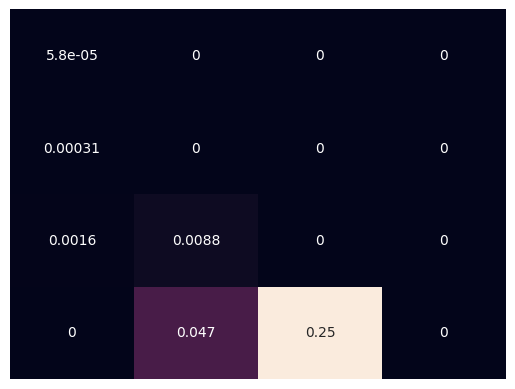

In [29]:
seaborn.heatmap(states, annot=True, cbar=False)
plt.axis("off")

plt.show()

In [ ]:
## (2.a) Policy iteration method for one strategy 

# Policy iteration method

In [70]:
def policy_iteration(states, policies):
    state_coords = [s0]

    for policy in policies:
        try:
            state_coords.append(apply_policy(state_coords[-1], policy))
        except OutOfWorldError:
            pass

    if len(state_coords) < len(policies):
        print("Invalid action")
        return

    for next_i in range(-1, -(len(policies) + 1), -1):
        curr_i = next_i - 1

        next_state_env = world_map[state_coords[next_i]][0]
        reward = rs.get(next_state_env)
        probab = ps.get(policies[next_i])
        states[state_coords[curr_i]] = probab*(reward + gamma*states[state_coords[next_i]])
    return states


<Axes: >

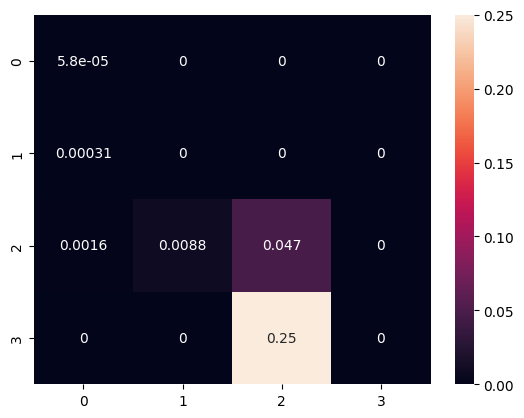

In [73]:
policies = ["down", "down", "right", "right", "down", "right"]
states_0 = policy_iteration(states=states, policies=policies)
seaborn.heatmap(states_0, annot=True)


In [30]:
states

array([[5.79357147e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.08990479e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.64794922e-03, 8.78906250e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.68750000e-02, 2.50000000e-01, 0.00000000e+00]])

## (2.b) System of Bellman's equations

In [12]:
import gymnasium as gym
from time import time

env = gym.make("FrozenLake-v1", 
                #    map_name="8x8", 
               is_slippery=False, 
               desc=["SFFF", 
                     "FHFH", 
                     "FFFH", 
                     "HFFG"],
                render_mode="human"
                )

env.reset()
env.render()


Generationg probability matrix

In [13]:
world_map.flatten()

array(['S', 'F', 'F', 'F', 'F', 'H', 'F', 'H', 'F', 'F', 'F', 'H', 'H',
       'F', 'F', 'G'], dtype='<U1')

In [22]:
def construct_probability_matrix(grid_size, env_matrix, blocking_state = "H"):
    n = grid_size ** 2  # Total number of states
    P = np.zeros((n, n), dtype=np.float32)
    env_matrix = env_matrix.flatten()
    
    for s in range(1, n + 1):
        row = s - 1  # Convert 1-based index to 0-based index

        # Initialize probabilities
        if row < n and env_matrix[row] == "H":
            prob_up = prob_down = prob_left = prob_right = 0
        else:
            prob_up = prob_down = prob_left = prob_right = 0.25

            if s <= grid_size:  # Top row (no up)
                prob_up = 0
            elif env_matrix[row - grid_size] == "H":
                prob_up = 0 
            if s > n - grid_size:  # Bottom row (no down)
                prob_down = 0
            elif env_matrix[row + grid_size] == "H":
                prob_down = 0
            if (s % grid_size) == 1:  # Left column (no left)
                prob_left = 0
            elif row - 1 >= 0 and env_matrix[row - 1] == "H":
                prob_left = 0
            if (s % grid_size) == 0:  # Right column (no right)
                prob_right = 0
            elif s < n and env_matrix[s] == "H":
                prob_right = 0

            # make eqiprobable movements to accessible cells  
            prob_sum = sum((prob_up, prob_down, prob_left, prob_right)) 
            prob = 1/3 if prob_sum == 0.75 else \
                     (1/2 if prob_sum == 0.5 else \
                      (1 if prob_sum == 0.25 else \
                       1/4))
        
            # Assign probabilities to the matrix
            if prob_up > 0:
                P[row, row - grid_size] = prob  # Move up
            if prob_down > 0:
                P[row, row + grid_size] = prob  # Move down
            if prob_left > 0:
                P[row, row - 1] = prob  # Move left
            if prob_right > 0:
                P[row, row + 1] = prob  # Move right
    # terminal state is absorbing one
    P[-1, -1] = 1 # environment specific! should be implemented in abstract way
    # no possible moves
    P[-1, -2] = 0 # move to the right
    P[-1, -grid_size] = 0 # move to up
    
    return P



In [ ]:
pm = construct_probability_matrix(4, env_matrix=world_map)
pm

In [24]:
np.sum(pm, axis=1)


array([1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1.],
      dtype=float32)

In [14]:
np.array([[rs.get(state) for state in row] for row in world_map]).flatten()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

Solving system of Eqs 

In [25]:
# finally form the system of bellman Eqs function
def get_states(grid_size: int, rewards: dict, environment: dict, gamma: float):
    P = construct_probability_matrix(grid_size, env_matrix=environment)
    
    # preparation
    R = np.array([[rewards.get(state) for state in row] for row in environment]).flatten()
    # make vector-like structure
    R = np.vstack(R)

    n = grid_size**2
    I = np.diag(np.full(n, 1, dtype=np.float32))

    # solve system of equations
    states = np.linalg.inv((I - gamma * P)) @ R
    states = states.reshape((grid_size, grid_size))
    return states


In [26]:
states_1 = get_states(grid_size=4, rewards=rs, environment=world_map, gamma=0.75) 

<Axes: >

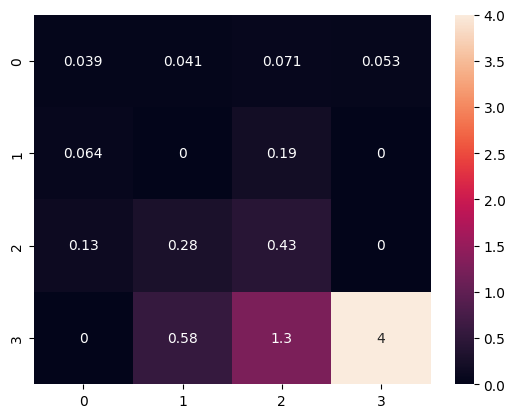

In [27]:
seaborn.heatmap(states_1, annot=True)

In [31]:
states_1

array([[0.03934948, 0.04121803, 0.07056525, 0.05292394],
       [0.06371392, 0.        , 0.18811905, 0.        ],
       [0.1305543 , 0.28443089, 0.43108556, 0.        ],
       [0.        , 0.57608372, 1.25179231, 4.        ]])

# FrozenLake sandbox

In [3]:
import gymnasium as gym
from time import time

In [4]:
env = gym.make("FrozenLake-v1", 
                #    map_name="8x8", 
               is_slippery=False, 
               desc=["SFFF", 
                     "FHFH", 
                     "FFFH", 
                     "HFFG"],
                render_mode="human"
                )

env.reset()
env.render()

In [7]:
env.__dir__()

['_saved_kwargs',
 'env',
 '_action_space',
 '_observation_space',
 '_metadata',
 '_cached_spec',
 '_max_episode_steps',
 '_elapsed_steps',
 '__module__',
 '__doc__',
 '__init__',
 'step',
 'reset',
 'spec',
 '__orig_bases__',
 '__parameters__',
 'render',
 'close',
 'np_random_seed',
 'unwrapped',
 'wrapper_spec',
 'has_wrapper_attr',
 'get_wrapper_attr',
 'set_wrapper_attr',
 '__str__',
 '__repr__',
 'class_name',
 'action_space',
 'observation_space',
 'metadata',
 'render_mode',
 'np_random',
 '_np_random',
 '__annotations__',
 '_np_random_seed',
 '__enter__',
 '__exit__',
 '__dict__',
 '__weakref__',
 '__class_getitem__',
 '__init_subclass__',
 '__new__',
 '__hash__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__getstate__',
 '__subclasshook__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [62]:
env_space = ["SFFF", 
             "FHFH", 
             "FFFH", 
             "HFFG"]

In [64]:
env_space = np.array([[s for s in line] for line in env_space])
env_space

In [69]:
# Construct all possible combinations
states_ids = np.arange(16).reshape((4, 4))
states_ids

In [93]:
s0 = (1, 0)
s_t = (3, 3)

In [106]:
chain = set(s0)

In [ ]:
if chain[0] != s_t:
    if s0[0] > 0:
        chain.append(s0[0] - 1, s0[1])
    